[**Demo %s**](#demo-nlsq-MM)

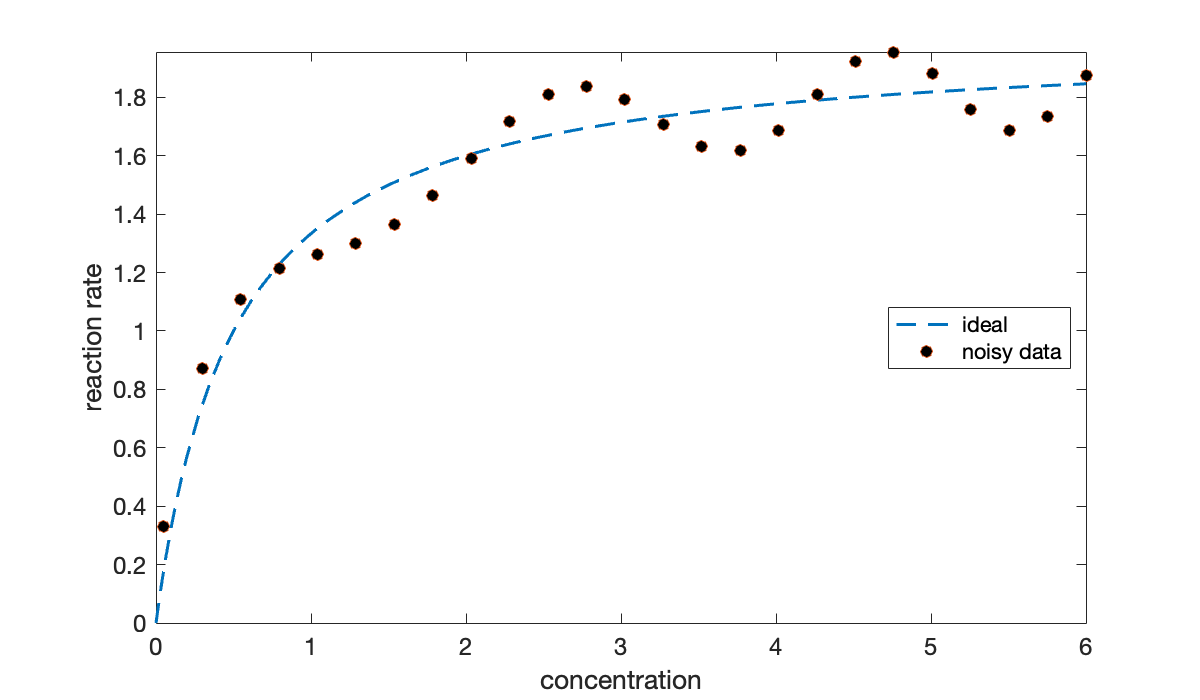

In [2]:
m = 25; V = 2; Km = 0.5;
s = linspace(0.05, 6, m)';
w = V * s ./ (Km + s);                      % exactly on the curve
w = w + 0.15 * cos(2 * exp(s / 16) .* s);   % noise added
clf, fplot(@(s) V * s ./ (Km + s), [0, 6], '--')
hold on, scatter(s, w)
xlabel('concentration'), ylabel('reaction rate')    
labels = ["ideal", "noisy data"];    
legend(labels, 'location', 'east');

The idea is to pretend that we know nothing of the origins of this data and use nonlinear least squares to find the parameters in the theoretical model function $v(s)$. In {eq}`nlsq-misfit`, the $s$ variable plays the role of $t$, and $v$ plays the role of $g$. In the Jacobian, the derivatives are with respect to the parameters in $\mathbf{x}$.

```{literalinclude} f47_misfit.m
:language: matlab
```

The misfit function above has to know the parameters `x` that are being optimized as well as the data `s` and `w` that remain fixed. We use a closure to pass the data values along.

In [3]:
f = @(x) f47_misfit(x, s, w);

Now we have a function that accepts a single 2-vector input and returns a 25-vector output. We can pass this function to `levenberg` to find the best-fit parameters.

In [4]:
x1 = [1; 0.75];
x = newtonsys(f, x1);
V = x(1, end),  Km = x(2, end)     % final values
model = @(s) V * s ./ (Km + s);    % best-fit model

V = 1.9687

Km = 0.4693

The final values are reasonably close to the values $V=2$, $K_m=0.5$ that we used to generate the noise-free data. Graphically, the model looks close to the original data:

final_misfit_norm = 0.5234

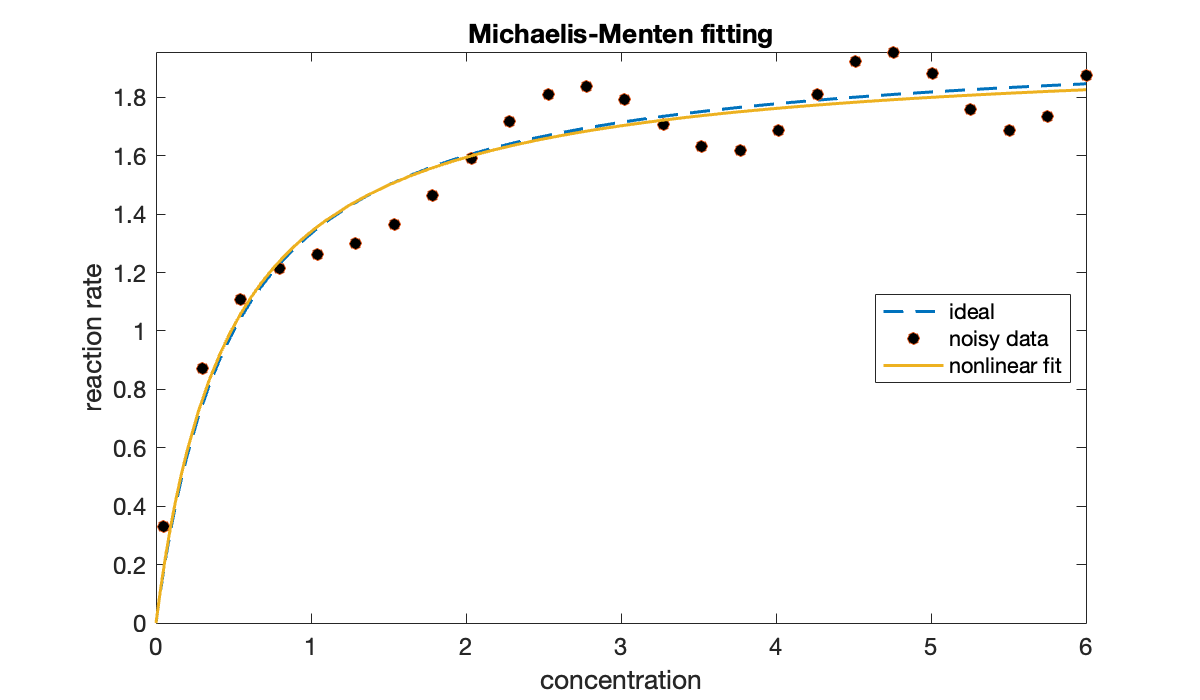

In [5]:
final_misfit_norm = norm(model(s) - w) 
hold on, fplot(model, [0, 6])
title('Michaelis-Menten fitting')    
labels = [labels, "nonlinear fit"];    
legend(labels, 'location', 'east');

For this particular model, we also have the option of linearizing the fit process. Rewrite the model as 

```{math}
:enumerated: false
\frac{1}{w} = \frac{\alpha}{s} + \beta = \alpha \cdot s^{-1} + \beta
```

for the new fitting parameters $\alpha=K_m/V$ and $\beta=1/V$. This corresponds to the misfit function whose entries are

$$f_i([\alpha,\beta]) = \left(\alpha \cdot \frac{1}{s_i} + \beta\right) - \frac{1}{w_i}$$

for $i=1,\ldots,m$. Although this misfit is nonlinear in $s$ and $w$, it's linear in the unknown parameters $\alpha$ and $\beta$. This lets us pose and solve it as a linear least-squares problem.

In [6]:
u = 1 ./ w;
A = [s.^(-1), s.^0];  
z = A \ u;
alpha = z(1);  beta = z(2);

The two fits are different because they do not optimize the same quantities.

final_misfit_linearized = 0.7487

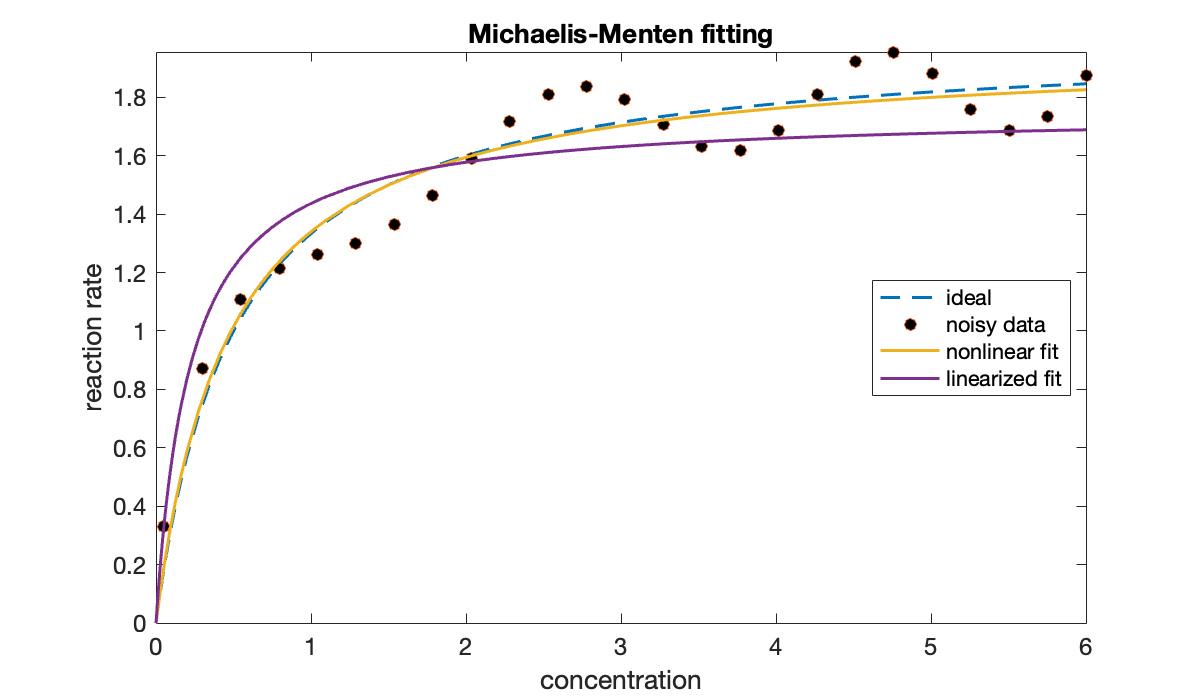

In [7]:
linmodel = @(s) 1 ./ (beta + alpha ./ s);
final_misfit_linearized = norm(linmodel(s) - w)
fplot(linmodel, [0, 6])
labels = [labels, "linearized fit"];    
legend(labels, 'location', 'east');

The truly nonlinear fit is clearly better in this case. It optimizes a residual for the original measured quantity rather than a transformed one we picked for algorithmic convenience.